In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils import check_X_y, check_array
from sklearn.exceptions import NotFittedError
from scipy.sparse.linalg import lsmr
from sklearn.linear_model import LinearRegression,LogisticRegression

from sklearn.model_selection import KFold
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor,StackingCVRegressor
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pymannkendall as mk
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf



from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


# Time Series Analysis Functions

## Reading Files

In [2]:
def Read_GNSS_Data(gnss_file_path):
    data = pd.read_csv(gnss_file_path)
    data['date'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY']])
    data.set_index('date', inplace=True)
    return data

In [3]:
def Read_ERA5_Data(ERA5_file_path):
    ERA_5 = pd.read_csv(ERA5_file_path)
    ERA_5['date'] = pd.to_datetime(ERA_5['date'])
    ERA_5.set_index('date', inplace=True)
    return ERA_5

## Station Extraction

In [4]:

def Station_Extraction(STATION_NAME,data):
    return data[data['STN']== STATION_NAME]


In [5]:
def ERA5_STATION_EXTRACTION(STATION_NAME,ERA_5):
    return ERA_5[ERA_5['station']== STATION_NAME]
    

In [6]:
def Extract_individual_Year_of_Station(EXTRACTED_STATION,YEAR):
    return EXTRACTED_STATION[EXTRACTED_STATION['YEAR'] == YEAR]


In [7]:
# data = Read_GNSS_Data("IGS_ALL_DATA_DAILY_OSAH_imputed.csv")

In [8]:
# ABPO_STATION = Station_Extraction('ABPO',data)

In [1]:
def Corelation_Analysis(Station,data,ERA_5):
    ERA_STATION = ERA5_STATION_EXTRACTION(Station,ERA_5)
    GNSS_STATION = Station_Extraction(Station,data)
    plt.figure(figsize=(8, 2))
    plt.plot(ERA_STATION['pwv [m]'],label='ERA5 PWV')
    plt.plot(GNSS_STATION['PWV_GTrop [K](mm)'],label='GNSS PWV')
    plt.ylabel('PWV',fontsize=12,fontweight='bold')
    plt.xlabel('Years',fontsize=12,fontweight='bold')
    plt.title('Superimpose GNSS on ERA5',fontsize=13,fontweight='bold')
    plt.legend()
    plt.show()
    return ERA_STATION['pwv [m]'].corr(GNSS_STATION['PWV_GTrop [K](mm)'])

## Stationarity Analysis

In [10]:
def Stationarity(STATION_NAME):
    result = adfuller(STATION_NAME['PWV_GTrop [K](mm)'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

## Mankendall Trend Test Analysis

In [11]:
def Mankendall_Trend_Test(STATION_NAME):
    result = mk.hamed_rao_modification_test(STATION_NAME['PWV_GTrop [K](mm)'])
    print('Trend:', result.trend)
    print('H:', result.h)
    print('p-value:', result.p)
    print('Z:', result.z)

## Plotting

In [12]:
# SinglePlot(ABPO_STATION )

In [13]:
def SinglePlot(EXTRACTED_STATION_NAME):
    station_2015 = Extract_individual_Year_of_Station(EXTRACTED_STATION_NAME,2015)
    
    fig, axs = plt.subplots(5, 3,figsize=(15, 14))
    annual_decomposition = sm.tsa.seasonal_decompose(station_2015['PWV_GTrop [K](mm)'], model='additive',period=30)
    semi_annual_decomposition = sm.tsa.seasonal_decompose(station_2015['PWV_GTrop [K](mm)'], model='additive',period=182)
    inter_annual_decomposition = sm.tsa.seasonal_decompose(EXTRACTED_STATION_NAME['PWV_GTrop [K](mm)'], model='additive',period=365)
    
    df = EXTRACTED_STATION_NAME
    df['Inter-Annual'] = df['PWV_GTrop [K](mm)'].diff(12)  # Assuming monthly data with a frequency of 12
    axs[0, 0].plot(EXTRACTED_STATION_NAME['PWV_GTrop [K](mm)'].index, EXTRACTED_STATION_NAME['PWV_GTrop [K](mm)'],color='red',label = 'PWV')
    axs[0, 0].set_title('PWV')
    axs[0, 0].set_ylabel('PWV')

    axs[0, 1].plot(df.index, df['Inter-Annual'],color='orange',label = 'PWV')
    axs[0, 1].set_title('Inter Annual Variability')
    axs[0, 1].set_ylabel('Interannual biases')
    
    axs[1, 1].plot(annual_decomposition.trend.index, annual_decomposition.trend,color='blue',label = 'PWV')
    axs[1, 1].set_title('2015 Annual Trend')
    axs[1, 1].set_ylabel(' Annual Trend ')
    plt.setp(axs[1, 1].get_xticklabels(), rotation=45)
    axs[1, 0].plot(annual_decomposition.seasonal.index, annual_decomposition.seasonal,color='orange',label = 'PWV')
    axs[1, 0].set_title('2015 Annual Seasonal')
    axs[1, 0].set_ylabel(' Annual Seasonal ')
    plt.setp(axs[1, 0].get_xticklabels(), rotation=45)
    axs[1, 2].plot(annual_decomposition.resid.index, annual_decomposition.resid,color='black',label = 'Residual')
    axs[1, 2].set_title(' 2015 Annual Residual')
    axs[1, 2].set_ylabel('Annual Residual')
    plt.setp(axs[1, 2].get_xticklabels(), rotation=45)
    
    
    axs[2, 1].plot(semi_annual_decomposition.trend.index, semi_annual_decomposition.trend,color='blue',label = 'PWV')
    axs[2, 1].set_title('2015 Semi Annual Trend')
    axs[2, 1].set_ylabel(' Semi Annual Trend ')
    plt.setp(axs[2, 1].get_xticklabels(), rotation=45)
    axs[2, 0].plot(semi_annual_decomposition.seasonal.index, semi_annual_decomposition.seasonal,color='orange',label = 'PWV')
    axs[2, 0].set_title('2015 Semi Annual Seasonal')
    axs[2, 0].set_ylabel('Semi Annual Seasonal')
    plt.setp(axs[2, 0].get_xticklabels(), rotation=45)
    axs[2, 2].plot(semi_annual_decomposition.resid.index, semi_annual_decomposition.resid,color='black',label = 'Residual')
    axs[2, 2].set_title('2015 Semi-Annual Residual')
    axs[2, 2].set_ylabel('Semi Annual Residual')
    plt.setp(axs[2, 2].get_xticklabels(), rotation=45)

   
    
    axs[3, 1].plot(inter_annual_decomposition.trend.index, inter_annual_decomposition.trend,color='blue',label = 'PWV')
    axs[3, 1].set_title('Inter Annual Trend')
    axs[3, 1].set_ylabel(' Inter Annual Trend ')
    axs[3, 0].plot(inter_annual_decomposition.seasonal.index, inter_annual_decomposition.seasonal,color='orange',label = 'PWV')
    axs[3, 0].set_title('Inter Annual Seasonal')
    axs[3, 0].set_ylabel('Inter Annual Seasonal')
    axs[3, 2].plot(inter_annual_decomposition.resid.index, inter_annual_decomposition.resid,color='black',label = 'Residual')
    axs[3, 2].set_title('Inter-Annual Residual')
    axs[3, 2].set_ylabel('Inter Annual Residual')
    
    
    plot_pacf(EXTRACTED_STATION_NAME['ZTD_igs'],ax=axs[4, 0],color='red')
    axs[4, 0].set_title('Partial AutoCorrelation Analysis')
    axs[4, 0].set_ylabel('Partial Autocorrelation')
    axs[4, 0].set_xlabel('Lags')
    
    plot_acf(EXTRACTED_STATION_NAME['PWV_GTrop [K](mm)'],ax=axs[4, 1],color='red')
    axs[4, 1].set_title('AutoCorrelation Analysis')
    axs[4, 1].set_ylabel('Autocorrelation')
    axs[4, 1].set_xlabel('Lags')
  
    fig.subplots_adjust(hspace=0.7)
    

In [14]:
def Subplotting_Individual_Years(Year_STATIONS,station):

    fig, axs = plt.subplots(2, 4,figsize=(15, 8), sharey=True)
# Plot data on subplots
    axs[0, 0].plot(Year_STATIONS[0].index, Year_STATIONS[0]['PWV_GTrop [K](mm)'],color = 'red')
    axs[0, 0].set_title('2015')
    
    plt.setp(axs[0, 0].get_xticklabels(), rotation=45)

    axs[0, 1].plot(Year_STATIONS[1].index, Year_STATIONS[1]['PWV_GTrop [K](mm)'],color = 'red')
    axs[0, 1].set_title('2016')
    plt.setp(axs[0, 1].get_xticklabels(), rotation=45)

    axs[1, 0].plot(Year_STATIONS[2].index, Year_STATIONS[2]['PWV_GTrop [K](mm)'],color = 'red')
    axs[1, 0].set_title('2017')
    plt.setp(axs[1, 0].get_xticklabels(), rotation=45)

    axs[1, 2].plot(Year_STATIONS[3].index, Year_STATIONS[3]['PWV_GTrop [K](mm)'],color = 'red')
    axs[1, 2].set_title('2018')
    plt.setp(axs[1, 2].get_xticklabels(), rotation=45)

    axs[1, 3].plot(Year_STATIONS[4].index, Year_STATIONS[4]['PWV_GTrop [K](mm)'],color = 'red')
    axs[1, 3].set_title('2019')
    plt.setp(axs[1, 3].get_xticklabels(), rotation=45)

    axs[1, 1].plot(Year_STATIONS[5].index, Year_STATIONS[5]['PWV_GTrop [K](mm)'],color = 'red')
    axs[1, 1].set_title('2020')
    plt.setp(axs[1, 1].get_xticklabels(), rotation=45)

    axs[0, 2].plot(Year_STATIONS[6].index, Year_STATIONS[6]['PWV_GTrop [K](mm)'],color = 'red')
    axs[0, 2].set_title('2021')
    plt.setp(axs[0, 2].get_xticklabels(), rotation=45)

    axs[0, 3].plot(Year_STATIONS[7].index, Year_STATIONS[7]['PWV_GTrop [K](mm)'],color = 'red')
    axs[0, 3].set_title('2022')
    plt.setp(axs[0, 3].get_xticklabels(), rotation=45)
    fig.suptitle(f'STATION {station}')
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [15]:
def Superimpose_Different_Years_Single_Plot(Year_STATIONS):
    plt.figure(figsize=(13, 6))
    plt.plot(Year_STATIONS[0].index,Year_STATIONS[0]['PWV_GTrop [K](mm)'],color='red' )
    plt.plot(Year_STATIONS[1].index,Year_STATIONS[1]['PWV_GTrop [K](mm)'],color='blue' )
    plt.plot(Year_STATIONS[2].index,Year_STATIONS[2]['PWV_GTrop [K](mm)'],color='yellow' )
    plt.plot(Year_STATIONS[3].index,Year_STATIONS[3]['PWV_GTrop [K](mm)'],color='purple' )
    plt.plot(Year_STATIONS[4].index,Year_STATIONS[4]['PWV_GTrop [K](mm)'],color='pink' )
    plt.plot(Year_STATIONS[5].index,Year_STATIONS[5]['PWV_GTrop [K](mm)'],color='green' )
    plt.plot(Year_STATIONS[6].index,Year_STATIONS[6]['PWV_GTrop [K](mm)'],color='black' )
    plt.plot(Year_STATIONS[7].index,Year_STATIONS[7]['PWV_GTrop [K](mm)'],color='orange' )
    plt.title('Annual Visualization',fontsize=20,fontweight='bold')
    plt.ylabel('PWV')

In [16]:
def Seasonal_TrendpPlotting(STATION_NAME):
    df_YEARLY = STATION_NAME.resample('m').sum()
    decomposition = sm.tsa.seasonal_decompose(df_YEARLY['PWV_GTrop [K](mm)'], model='additive')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    decomposition.trend.plot(ax=ax1)
    ax1.set_title('Trend')
    decomposition.seasonal.plot(ax=ax2)
    ax2.set_title('Seasonal')
    
    plt.tight_layout()
    plt.show()
    

In [17]:
def Atmostpheric_Plot_With_GNSS(STATION,data,ERA_5):
    GNSS_STATION = Station_Extraction(STATION,data)
    ERAS_STATTION = ERA5_STATION_EXTRACTION(STATION,ERA_5)
    fig, axs = plt.subplots(1, 4,figsize=(20, 6))
    

    axs[0].plot(GNSS_STATION['PWV_GTrop [K](mm)'],color='red')
    axs[0].set_title('PWV',fontsize=10,fontweight='bold')
    axs[0].set_ylabel('PWV',fontsize=12,fontweight='bold')
    axs[0].set_xlabel('Years',fontsize=12,fontweight='bold')
    
    
    plt.setp(axs[0].get_xticklabels(), rotation=45)
#     plt.setp(ax2.get_xticklabels(), rotation=45)
    

    axs[1].plot(ERAS_STATTION['T [K]'].index,ERAS_STATTION['T [K]'],color='blue')
    axs[1].set_title('Atmospheric Temperature',fontsize=10,fontweight='bold')
    plt.setp(axs[1].get_xticklabels(), rotation=45)
    axs[1].set_ylabel('Temperature(K)',fontsize=12,fontweight='bold')
    axs[1].set_xlabel('Years',fontsize=12,fontweight='bold')
   
   
    
    axs[2].plot(ERAS_STATTION['p [hPa]'].index,ERAS_STATTION['p [hPa]'],color='orange')
    axs[2].set_title('Atmospheric Pressure',fontsize=10,fontweight='bold')
    axs[2].set_ylabel('Pressure(hPa)',fontsize=12,fontweight='bold')
    axs[2].set_xlabel('Years',fontsize=12,fontweight='bold')
    plt.setp(axs[2].get_xticklabels(), rotation=45)
   
   
    
    axs[3].plot(ERAS_STATTION['p [hPa]'].index,ERAS_STATTION['e [hPa]'],color='black')
    axs[3].set_title('Atmospheric Partial Water Vapour Pressure',fontsize=10,fontweight='bold')
    axs[3].set_ylabel('Partial Pressure(hPa)',fontsize=12,fontweight='bold')
    axs[3].set_ylabel('Years',fontsize=12,fontweight='bold')
 
    plt.setp(axs[3].get_xticklabels(), rotation=45)
   

In [18]:
def Mankendall_Trend_Test_Plot(STATION_NAME,data):
    trend_annual_pvalues,trend_semi_annual_pvalues, trend_inter_innual_pvalues =[],[],[]
    seasonal_annual_pvalues,seasonal_semi_annual_pvalues, seasonal_inter_innual_pvalues =[],[],[]
    station_names = data ['STN'].drop_duplicates()
    
    fig, ax = plt.subplots(figsize=(13, 6),sharey=True)
    for stn in STATION_NAME:
        annual = stn.resample('m').mean()
        
        semiannual = stn.resample('6m').mean()
        interiannual = stn.resample('y').mean()
        
        result1 = mk.hamed_rao_modification_test(annual['PWV_GTrop [K](mm)'])
        seasonal_annual_pvalues.append(mk.seasonal_test(annual,period=1).p)
        trend_annual_pvalues.append (result1.p)
        
        result2 = mk.hamed_rao_modification_test(semiannual['PWV_GTrop [K](mm)'])
        seasonal_semi_annual_pvalues.append(mk.seasonal_test(semiannual,period=1).p)
        trend_semi_annual_pvalues.append (result2.p)
        
        result3 = mk.hamed_rao_modification_test(interiannual['PWV_GTrop [K](mm)'])
        seasonal_inter_innual_pvalues.append(mk.seasonal_test(interiannual,period=1).p)
        trend_inter_innual_pvalues.append (result3.p)
#     plt.bar(station_names.values, p_values,width=0.3)
#     plt.xticks(rotation=45)  # Rotate the x-labels by 45 degrees
   
#     y_value = 10
    ax.axhline(y=0.05, color='red', linestyle='--',label='Seasonality Significant level')
    ax.annotate('p-value = 0.05',xy=(0.5,0.05),xytext=(0,0.09+0.9),color='r',arrowprops=dict(arrowstyle='->',color='black'),fontsize=10,fontweight='bold')
    x = np.arange(len(station_names))
    
#     ax.bar(x-0.25, trend_annual_pvalues,width=0.25,color = 'orange',label = 'Annual Mankendall Trend Test')
#     ax.bar(x,trend_semi_annual_pvalues,width=0.25,color ='blue',label = 'Semi-Annual Mankendall Trend Test')
#     ax.bar(x+0.2,trend_inter_innual_pvalues,width=0.25,color ='green',label = 'Inter-Annual Mankendall Trend Test')
    
    ax.bar(x-0.25, seasonal_annual_pvalues,width=0.25,color = 'orange',label = 'Annual Mankendall Seasonality')
    ax.bar(x,seasonal_semi_annual_pvalues,width=0.25,color ='blue',label = 'Semi-Annual Mankendall Seasonality')
    ax.bar(x+0.2,seasonal_inter_innual_pvalues,width=0.25,color ='green',label = 'Inter-Annual Mankendall Seasonality')
    
    

    group_x = x - 0.25 / 2 
#     ax.set_xticks(group_x)
#     ax.set_xticklabels(station_names,rotation=45)
#     ax.set_ylabel('Mankendal Trend  p-values',fontsize=12,fontweight='bold')
#     ax.set_xlabel('Stations',fontsize=12,fontweight='bold')
    
    ax.set_xticks(group_x)
    ax.set_xticklabels(station_names,rotation=45)
    ax.set_xlabel('Stations',fontsize=12,fontweight='bold')
    ax.set_ylabel('Mankendal Seasonality  values',fontsize=12,fontweight='bold')
    

  
    
    
    


#     ax.set_title('CORRELATION BETWEEN GNSS(ZTD_igs), TEMPERATURE(T [K]), ATMOSPHERIC PRESSURE(p [hPa]) AND ATMOSPHERIC PARTIAL WATER VAPOUR PRESSURE(e [hPa])')

 
    ax.legend(fontsize=10)
    return seasonal_annual_pvalues,seasonal_inter_innual_pvalues
 
#     ax[0,1].legend()

    
    
#     plt.xlabel('Station Names')
#     plt.ylabel('Mankendall P-values')
#     plt.title('Trend Analysis with Mankendall Statistics Test')
#     plt.show()


In [19]:
# Mankendall_Trend_Test_Plot(STATION_NAME,data)

In [20]:
# data = Read_GNSS_Data("IGS_ALL_DATA_DAILY_OSAH_imputed.csv")
# ERA_5 = Read_ERA5_Data('ERA_5.CSV')
# Replace_GNSS_with_Era(data,ERA_5,'PWV_GTrop [K](mm)','pwv [m]')
# Station_Extraction('ABPO',data).resample('6m').mean()['PWV_GTrop [K](mm)']

# stations = []
# for item in ['ABPO','ADIS','BJCO','CGGN','CPVG','DAKR','DEAR','DJIG','HARB','HNUS','HRAO','MAL2','MBAR','MFKG','MOIU','NKLG','NURK','RABT','RBAY','RCMN','SBOK','SEY2','SEYG','SUTH','SUTM','TDOU','ULDI','VACS','WIND','YKRO','ZAMB']:
#     stations.append(Station_Extraction(item,data))
    

# Mankendall_Trend_Test_Plot(stations,data)

In [21]:
# Seasonal_TrendpPlotting(Station_Extraction('ABPO',data).resample('6m').mean()['PWV_GTrop [K](mm)'])
# sm.tsa.seasonal_decompose(Station_Extraction('CGGN',data).resample('y').mean()['PWV_GTrop [K](mm)'], model='additive').plot()

In [22]:
def Mankendall_Trend_Test_Cluster(STATION_NAME,data):
    annual_cluster_value,semi_annual_cluster_value, inter_innual_cluster_value =[],[],[]
    station_names = data ['STN'].drop_duplicates()
    plt.figure(figsize=(13, 6))
    for stn in STATION_NAME:
        annual = stn.resample('m').mean()
        semiannual = stn.resample('6m').mean()
        interiannual = stn.resample('y').mean()
        
        result1 = mk.hamed_rao_modification_test(annual['PWV_GTrop [K](mm)'])
        annual_trend =result1.trend
        if annual_trend=='increasing':
            annual_cluster_value.append(1)
        elif annual_trend=='decreasing':
            annual_cluster_value.append(-1)
        elif annual_trend=='no trend':
            annual_cluster_value.append(0)
            
        result2 = mk.hamed_rao_modification_test(semiannual['PWV_GTrop [K](mm)'])
        semi_trend =result2.trend
        if semi_trend=='increasing':
            semi_annual_cluster_value.append(1)
        elif semi_trend=='decreasing':
            semi_annual_cluster_value.append(-1)
        elif semi_trend=='no trend':
            semi_annual_cluster_value.append(0)
            
        result3 = mk.hamed_rao_modification_test(interiannual['PWV_GTrop [K](mm)'])
        inter_trend =result3.trend
        if inter_trend=='increasing':
            inter_innual_cluster_value.append(1)
        elif inter_trend=='decreasing':
            inter_innual_cluster_value.append(-1)
        elif inter_trend=='no trend':
            inter_innual_cluster_value.append(0)
            
            
            
        
    annual_legend_mapping = { -1: "Decreasing Trend(Annual)", 0: "No Trend(Annual)", 1: "Increasing Trend(Annual)"}
    annual_renamed_labels = [annual_legend_mapping[label] for label in annual_cluster_value]
    annual_dataframe = pd.DataFrame({'Annual_cluster_values':annual_cluster_value,'station_names':station_names})
    sns.scatterplot(data=annual_dataframe, x='station_names', y='Annual_cluster_values',hue=annual_renamed_labels, palette=['red','blue','orange'])
    
    semi_legend_mapping = { -1: "Decreasing Trend(Semi Annual)", 0: "No Trend(Semi Annual)", 1: "Increasing Trend(Semi Annual)"}
    semi_renamed_labels = [semi_legend_mapping[label] for label in semi_annual_cluster_value]
    semi_dataframe = pd.DataFrame({'Semi_cluster_values':semi_annual_cluster_value,'station_names':station_names})
    sns.scatterplot(data=semi_dataframe, x='station_names', y='Semi_cluster_values',hue=semi_renamed_labels, palette=['green','black','violet'])
    
    inter_legend_mapping = { -1: "Decreasing Trend(Inter_Annual)", 0: "No Trend(Inter_Annual)", 1: "Increasing Trend(Inter_Annual)"}
    inter_renamed_labels = [inter_legend_mapping[label] for label in inter_innual_cluster_value]
    interdataframe = pd.DataFrame({'inter_cluster_values':inter_innual_cluster_value,'station_names':station_names})
    sns.scatterplot(data=interdataframe, x='station_names', y='inter_cluster_values',hue=inter_renamed_labels, palette=['purple','cyan','magenta'])
    
    plt.xticks(rotation=45) 

    plt.xlabel('Station Names',fontsize=12,fontweight='bold')
    plt.ylabel('cluster Values',fontsize=12,fontweight='bold')
 

In [23]:
# data = Read_GNSS_Data("IGS_ALL_DATA_DAILY_OSAH_imputed.csv")

# stations = []
# for item in ['ABPO','ADIS','BJCO','CGGN','CPVG','DAKR','DEAR','DJIG','HARB','HNUS','HRAO','MAL2','MBAR','MFKG','MOIU','NKLG','NURK','RABT','RBAY','RCMN','SBOK','SEY2','SEYG','SUTH','SUTM','TDOU','ULDI','VACS','WIND','YKRO','ZAMB']:
#     stations.append(Station_Extraction(item,data))
    

# Mankendall_Trend_Test_Cluster(stations,data)

In [24]:
def Trend_and_Stationarity_Visualisation(Stations,data):
    Mankendall_p_values = []
    stationarity_p_values = []
    fig, ax = plt.subplots(figsize=(13, 6))
    station_names = data ['STN'].drop_duplicates()
    for item in Stations:
        
        Mankendall_result = mk.hamed_rao_modification_test(item['PWV_GTrop [K](mm)'])
        Mankendall_p_values.append ( Mankendall_result.p)
        
        Stationarity_result = adfuller(item['PWV_GTrop [K](mm)'])
        stationarity_p_values.append(Stationarity_result[1])
        

    x = np.arange(len(station_names))
    
        
    ax.bar(x-0.3, Mankendall_p_values,width=0.3,color = 'red',label = 'Mankendal')
    ax.bar(x,stationarity_p_values,width=0.3,color ='blue',label = 'Stationarity')
    

    group_x = x - 0.3 / 2 
    ax.set_xticks(group_x)
    ax.set_xticklabels(station_names,rotation=45)

  
    
    
    ax.set_ylabel('P values')


    ax.set_title('Stationarity and Trend Visualisation')

 
    ax.legend()
    



In [25]:
def Corelation_Analysis_Plot(Station,data,ERA_5):
    correlation = []
    plt.figure(figsize=(15, 6))
    station_names = data ['STN'].drop_duplicates()
    for item in Station:
        ERA_STATION = ERA5_STATION_EXTRACTION(item,ERA_5)
        GNSS_STATION = Station_Extraction(item,data)
        
        
        correlation.append(ERA_STATION['pwv [m]'].corr(GNSS_STATION['PWV_GTrop [K](mm)']))
        
    plt.bar(station_names, correlation,width=0.3)
    plt.xticks(rotation=45)  
    plt.xlabel('Station Names',fontsize=12,fontweight='bold')
    plt.ylabel('Correlation Values',fontsize=12,fontweight='bold')
    plt.title('Correlation Analysis with Adfuller Statistics Test',fontsize=10,fontweight='bold')
    
    plt.show()

In [26]:
def GNSS_AND_ATMOSPHERIC_PARAMETER_CORRELATTION(Station,data,ERA_5):
    GNSS_Temperature_correlation = []
    GNSS_Pressure_correlation = []
    GNSS_Partial_Water_Vapour_Pressure_correlation = []
    fig, ax = plt.subplots(figsize=(13, 6))
    station_names = data ['STN'].drop_duplicates()
    for item in Station:
        ERA_STATION = ERA5_STATION_EXTRACTION(item,ERA_5)
        GNSS_STATION = Station_Extraction(item,data)
        GNSS_Temperature_correlation.append(ERA_STATION['T [K]'].corr(GNSS_STATION['PWV_GTrop [K](mm)']))
        GNSS_Pressure_correlation.append(ERA_STATION['p [hPa]'].corr(GNSS_STATION['PWV_GTrop [K](mm)']))
        GNSS_Partial_Water_Vapour_Pressure_correlation.append(ERA_STATION['e [hPa]'].corr(GNSS_STATION['PWV_GTrop [K](mm)']))
    x = np.arange(len(station_names))
    
    ax.bar(x-0.25, GNSS_Temperature_correlation,width=0.25,color = 'red',label = 'GNSS AND TEMPERATURE CORELLATION')
    ax.bar(x,GNSS_Pressure_correlation,width=0.25,color ='blue',label = 'GNSSS AND PRESSURE CORRELATION')
    ax.bar(x+0.2,GNSS_Partial_Water_Vapour_Pressure_correlation,width=0.25,color ='green',label = 'GNSS AND PARTIAL WATER VAPOUR CORRELATION')
    

    group_x = x - 0.25 / 2 
    ax.set_xticks(group_x)
    ax.set_xticklabels(station_names,rotation=45)

  
    
    
    ax.set_ylabel('Correlation  values',fontsize=12,fontweight='bold')
    ax.set_xlabel('Stations',fontsize=12,fontweight='bold')


#     ax.set_title('CORRELATION BETWEEN GNSS(ZTD_igs), TEMPERATURE(T [K]), ATMOSPHERIC PRESSURE(p [hPa]) AND ATMOSPHERIC PARTIAL WATER VAPOUR PRESSURE(e [hPa])')

 
    ax.legend(fontsize=10)

# Time Series Prediction

## Autogressive Forcasting

In [27]:
def Autoregressive_Forecasting(Station_Name,Lag):
    train_data = Station_Name.iloc[:-500]  # n is the number of data points to use for testing
    test_data = Station_Name.iloc[-500:]
    model = sm.tsa.AutoReg(train_data['PWV_GTrop [K](mm)'], Lag)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    compare = pd.DataFrame({'Actual':test_data['PWV_GTrop [K](mm)'],'Predicted':predictions })
    rmse = np.sqrt(mean_squared_error(test_data['PWV_GTrop [K](mm)'].values.flatten(), predictions.values.flatten()))
   
    plt.figure(figsize=(12, 8))
#     plt.plot(Station_Name['PWV_GTrop [K](mm)'], label='Original Series')
    plt.plot(test_data['PWV_GTrop [K](mm)'], label='tested Series',color='y')
    plt.plot(predictions, label='MA Predictions',color='r')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    return model_fit.summary(),compare.head(10),f'the root mean square is {rmse}',predictions


In [28]:

# data = Read_GNSS_Data("IGS_ALL_DATA_DAILY_OSAH_imputed.csv")
# ERA_5 = Read_ERA5_Data('ERA_5.CSV')
# Replace_GNSS_with_Era(data,ERA_5,'PWV_GTrop [K](mm)','pwv [m]')
# ABPO_STATION = Station_Extraction('ABPO',data)

In [29]:
# Autoregressive_Forecasting(ABPO_STATION,3)

In [30]:
# model = auto_arima(ABPO_STATION[:80]['ZTD_igs'], stepwise=True,trace=True)

## Moving Average Forcasting

In [31]:
def Moving_Average(Station_Name, lag):
    train_data = Station_Name.iloc[:-500]  # n is the number of data points to use for testing
    test_data = Station_Name.iloc[-500:]
    model = ARIMA(train_data['PWV_GTrop [K](mm)'], order=(0,0,lag))
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    compare = pd.DataFrame({'Actual':test_data['PWV_GTrop [K](mm)'],'Predicted':predictions })
    rmse = np.sqrt(mean_squared_error(test_data['PWV_GTrop [K](mm)'].values.flatten(), predictions.values.flatten()))
   
    plt.figure(figsize=(12, 8))
#     plt.plot(Station_Name['PWV_GTrop [K](mm)'], label='Original Series')
    plt.plot(test_data['PWV_GTrop [K](mm)'], label='tested Series',color='y')
    plt.plot(predictions, label='MA Predictions',color='r')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    return model_fit.summary(),compare.head(10),f'the root mean square is {rmse}',predictions

In [32]:
# Moving_Average(ABPO_STATION, 4)

In [33]:
# ABPO_STATION=Station_Extraction('ABPO',data)

## ARIMA and SARIMA

In [34]:
def Sarima_Prediction(Station_Name):
    train_data = Station_Name.iloc[:-20]  # n is the number of data points to use for testing
    test_data = Station_Name.iloc[-20:]

    

#     stepwise_model = auto_arima(train_data['ZTD_igs'], stepwise=True, trace=True)
    model = sm.tsa.SARIMAX(train_data['PWV_GTrop [K](mm)'], order=(2,0,2), seasonal_order=(0,0,0,0))
  
    ar_model = model.fit()  # maxlag determines the lag order.

    get_test=ar_model.get_forecast(len(test_data.index))
    predict_df=get_test.conf_int(alpha=0.05)
    predict_df['forecast'] = ar_model.predict(start=predict_df.index[0], end=predict_df.index[-1])
    

    rmse = np.sqrt(mean_squared_error(test_data['PWV_GTrop [K](mm)'].values.flatten(), predict_df['forecast']))

    compare = pd.DataFrame({'Date':test_data['PWV_GTrop [K](mm)'].index,'Actual':test_data['PWV_GTrop [K](mm)'],'Predicted':predict_df['forecast']})
#     return compare
    fig, ax = plt.subplots(2,1,figsize=(13, 12))
    ax[0].plot(compare['Actual'],color ='yellow',label ='tested data')
#     ax[0,0].scatter(Station_Name['ZTD_igs'],color='blue',label = 'original data')
    ax[0].plot(compare['Predicted'],color='red',label ='prediction')
    ax[0].fill_between( predict_df.index,  predict_df['lower PWV_GTrop [K](mm)'],  predict_df['upper PWV_GTrop [K](mm)'], color='black', alpha=0.4,label='Confident Level Region') 

    
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Value')
   

#     ax[1,1].scatter(compare['Date'],compare['Actual'],label='Actual;',color='red')
#     ax[1,1].scatter(compare['Date'],compare['Predicted'],label='Predicted',color='blue')
#     slope, intercept = np.polyfit(compare['Actual'], compare['Predicted'], 1)
#     ax[1,1].plot(compare['Actual'], slope * compare['Actual'] + intercept, color='red', label='Line of Best Fit')
    bias = compare['Actual']-compare['Predicted']
    ax[1].plot(bias,label ='Biases')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Bias')
    plt.setp(ax[0].get_xticklabels(), rotation=45)
    plt.setp(ax[1].get_xticklabels(), rotation=45)
    
#     ax[1,1].set_xlabel('Actual')
#     ax[1,1].set_ylabel('Predicted')
    ax[0].legend(fontsize=7)
    ax[1].legend()
    fig.subplots_adjust(hspace=0.5)
#     return predict_df
    return ar_model.summary(),compare.head(10),f'the root mean square is {rmse}',compare['Predicted']

In [35]:
# ABPO_STATION=Station_Extraction('ABPO',data)

In [36]:
# Sarima_Prediction(NURK_STATION)

In [37]:
def Arima_Forecasting(Station_Name,order):
    train_data = Station_Name.iloc[:-20]  # n is the number of data points to use for testing
    test_data = Station_Name.iloc[-20:]

    arima_model = ARIMA(train_data['PWV_GTrop [K](mm)'], order=order)
    arima_model_fit = arima_model.fit()
    arima_model_fit.summary()
    get_test= arima_model_fit.get_forecast(len(test_data.index))
    predict_df=get_test.conf_int(alpha=0.05)
    predict_df['forecast'] =  arima_model_fit.predict(start=predict_df.index[0], end=predict_df.index[-1])
    
#     arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)
    rmse = np.sqrt(mean_squared_error(test_data['PWV_GTrop [K](mm)'].values.flatten(), predict_df['forecast']))
    compare = pd.DataFrame({'Actual':test_data['PWV_GTrop [K](mm)'],'Predicted':predict_df['forecast']})
    fig,ax=plt.subplots(2,1,figsize=(13,8))
#     plt.plot(Station_Name['ZTD_igs'], label='Original Series')
    ax[0].plot(compare['Actual'], label='tested data',color='y')
    ax[0].plot(predict_df['forecast'], label='ARIMA Predictions',color='r')
    ax[0].fill_between( predict_df.index,  predict_df['lower PWV_GTrop [K](mm)'],  predict_df['upper PWV_GTrop [K](mm)'], color='grey', alpha=0.4,label='Confident Level Region')
    ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    bias = compare['Actual']-compare['Predicted']
    ax[1].plot(bias,label ='Biases')
    ax[1].set_xlabel('Time',fontsize=12,fontweight='bold')
    ax[1].set_ylabel('Bias',fontsize=12,fontweight='bold')
    ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.setp(ax[0].get_xticklabels(), rotation=45)
    plt.setp(ax[1].get_xticklabels(), rotation=45)

    
#     forecast, stderr, conf_int = results.forecast(steps=10, alpha=0.05)  # Replace 'steps' with the number of steps ahead you want to forecast
#     lower_conf_int, upper_conf_int = conf_int[:, 0], conf_int[:, 1]
    
    ax[0].legend(fontsize=10)
    ax[1].legend(fontsize=10)
    ax[0].set_xlabel('Time',fontsize=20,fontweight='bold')
    ax[0].set_ylabel('Value',fontsize=20,fontweight='bold')
    ax[1].set_xlabel('Time',fontsize=20,fontweight='bold')
    ax[1].set_ylabel('Bias',fontsize=20,fontweight='bold')
    fig.subplots_adjust(hspace=0.5)
  
    
    return arima_model_fit.summary(),compare.head(10),f'the root mean square is {rmse}'

In [38]:
# data = Read_GNSS_Data("IGS_ALL_DATA_DAILY_OSAH_imputed.csv")
# ERA_5 = Read_ERA5_Data('ERA_5.CSV')
# Replace_GNSS_with_Era(data,ERA_5,'PWV_GTrop [K](mm)','pwv [m]')


In [39]:
# model=auto_arima(NURK_STATION['PWV_GTrop [K](mm)'][:-20],stepwise=True, trace=True,seasonal=True)

In [40]:
# ABPO_STATION=Station_Extraction('ABPO',data).resample('m').mean()


In [41]:
# Arima_Forecasting(ABPO_STATION,(2,0,2))

In [42]:
def check_Stationarity(differenced_data):
    result = adfuller(differenced_data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

In [43]:
def check_Mankendall_Trend_Test(differenceddata):
    result = mk.hamed_rao_modification_test(differenceddata)
    print('Trend:', result.trend)
    print('H:', result.h)
    print('p-value:', result.p)
    print('Z:', result.z)

In [44]:
def Detrending(Station_name):
    fig, axs = plt.subplots(2, 2,figsize=(15, 14))
    axs[0,0].plot(Station_name['ZTD_igs'], label='Original Data')
    axs[0,0].set_xlabel('time')
    axs[0,0].set_ylabel('PWV_GTrop [K](mm)')
    axs[0, 0].set_title('Original Data')
    
    
    trend_differenced_data = Station_name['PWV_GTrop [K](mm)'].diff().dropna()
   
   
    
    axs[0,1].plot(trend_differenced_data, label='differenced')
    axs[0,1].set_xlabel('time')
    axs[0,1].set_ylabel('Z value')
    axs[0, 1].set_title('Differenced Data')
    
    plot_pacf(trend_differenced_data,ax=axs[1, 0],color='red')
    axs[1, 0].set_title('Partial AutoCorrelation Analysis')
    axs[1, 0].set_ylabel('Partial Autocorrelation')
    axs[1, 0].set_xlabel('Lags')
    
    plot_acf(trend_differenced_data,ax=axs[1, 1],color='red')
    axs[1, 1].set_title('AutoCorrelation Analysis')
    axs[1, 1].set_ylabel('Autocorrelation')
    axs[1, 1].set_xlabel('Lags')
    print(trend_differenced_data)
    return pd.DataFrame({'PWV_GTrop [K](mm)':trend_differenced_data}),check_Mankendall_Trend_Test(trend_differenced_data),check_Stationarity(trend_differenced_data)

# pd.Series(differenced_data)




In [45]:
def Deseasonalise(Station_name):
    fig, axs = plt.subplots(2, 2,figsize=(15, 14))
    axs[0,0].plot(Station_name['PWV_GTrop [K](mm)'], label='Original Data')
    axs[0,0].set_xlabel('time')
    axs[0,0].set_ylabel('Z value')
    axs[0, 0].set_title('Original Data')
    
    seasonal_differenced_data = Station_name['PWV_GTrop [K](mm)'].diff(periods=366).dropna()
    
    
    axs[0,1].plot(seasonal_differenced_data, label='differenced')
    axs[0,1].set_xlabel('time')
    axs[0,1].set_ylabel('Z value')
    axs[0, 1].set_title('Differenced Data')
    
    plot_pacf(seasonal_differenced_data,ax=axs[1, 0],color='red')
    axs[1, 0].set_title('Partial AutoCorrelation Analysis')
    axs[1, 0].set_ylabel('Partial Autocorrelation')
    axs[1, 0].set_xlabel('Lags')
    
    plot_acf(seasonal_differenced_data,ax=axs[1, 1],color='red')
    axs[1, 1].set_title('AutoCorrelation Analysis')
    axs[1, 1].set_ylabel('Autocorrelation')
    axs[1, 1].set_xlabel('Lags')
    
    return pd.DataFrame({'PWV_GTrop [K](mm)':seasonal_differenced_data}),check_Stationarity(seasonal_differenced_data)

In [46]:
def Remove_Trend_or_Seasonal(Station_Name,differencing_type):
    if differencing_type =='S':
        return Deseasonalise(Station_Name)
    elif differencing_type =='T':
        return Detrending(Station_Name)

# Machine_Learning_Forecasting

## Least Square Support vector Regression

In [92]:
class LSSVR(BaseEstimator, RegressorMixin):
    """Least Squares Support Vector Regression.

    Parameters
    ----------
    C : float, default=2.0
        Regularization parameter. The strength of the regularization is
        inversely proportional to C. Must be strictly positive.

    kernel : {'linear', 'rbf'}, default='linear'
        Specifies the kernel type to be used in the algorithm.
        It must be 'linear', 'rbf' or a callable.

    gamma : float, default = None
        Kernel coefficient for 'rbf'


    Attributes
    ----------
    support_: boolean np.array of shape (n_samples,), default = None
        Array for support vector selection.

    alpha_ : array-like
        Weight matrix

    bias_ : array-like
        Bias vector


    """

    def __init__(self, C=2.0, kernel='linear', gamma=None):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma

    def fit(self, X, y, support=None):
        """Fit the model according to the given training data.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data

        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values.

        support : boolean np.array of shape (n_samples,), default = None
            Array for support vector selection.

        Returns
        -------
        self : object
            An instance of the estimator.
        """

        X, y = check_X_y(X, y, multi_output=True, dtype='float')

        if not support:
            self.support_ = np.ones(X.shape[0], dtype=bool)
        else:
            self.support_ = check_array(support, ensure_2d=False, dtype='bool')

        self.support_vectors_ = X[self.support_, :]
        support_labels = y[self.support_]

        self.K_ = self.kernel_func(X, self.support_vectors_)
        omega = self.K_.copy()
        np.fill_diagonal(omega, omega.diagonal()+self.support_/self.C)

        D = np.empty(np.array(omega.shape) + 1)

        D[1:, 1:] = omega
        D[0, 0] = 0
        D[0, 1:] = 1
        D[1:, 0] = 1

        shape = np.array(support_labels.shape)
        shape[0] += 1
        t = np.empty(shape)

        t[0] = 0
        t[1:] = support_labels

        # TODO: maybe give access to  lsmr atol and btol ?
        try:
            z = lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t

        self.bias_ = z[0]
        self.alpha_ = z[1:]
        self.alpha_ = self.alpha_[self.support_]

        return self

    def predict(self, X):
        """
        Predict using the estimator.
        Parameters
        ----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            Samples.

        Returns
        -------
        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Returns predicted values.
        """

        if not hasattr(self, 'support_vectors_'):
            raise NotFittedError

        X = check_array(X, ensure_2d=False)
        K = self.kernel_func(X, self.support_vectors_)
        return (K @ self.alpha_) + self.bias_

    def kernel_func(self, u, v):
        if self.kernel == 'linear':
            return np.dot(u, v.T)

        elif self.kernel == 'rbf':
            return rbf_kernel(u, v, gamma=self.gamma)

        elif callable(self.kernel):
            if hasattr(self.kernel, 'gamma'):
                return self.kernel(u, v, gamma=self.gamma)
            else:
                return self.kernel(u, v)
        else:
            # default to linear
            return np.dot(u, v.T)

    def score(self, X, y):
        from scipy.stats import pearsonr
        p, _ = pearsonr(y, self.predict(X))
        return p ** 2

    def norm_weights(self):
        A = self.alpha_.reshape(-1, 1) @ self.alpha_.reshape(-1, 1).T

        W = A @ self.K_[self.support_, :]
        return np.sqrt(np.sum(np.diag(W)))


# Stacked Ensemble Modelling

In [100]:
def Stack_ensemble_Prediction(Station_Name):
    
#     train_start = '2015-01-01'
#     train_end = '2015-09-30'
#     test_start = '2015-10-01'
#     test_end = '2015-12-31'

    
#     training_data = Station_Name[(Station_Name.index >= train_start) & (Station_Name.index <= train_end)]
#     testing_data = Station_Name[(Station_Name.index >= test_start) & (Station_Name.index <= test_end)]
    
   
    
#     y_test_df = testing_data['PWV_GTrop [K](mm)']
    
#     X_train = training_data[['ZTD_igs','DOY','YEAR','LAT','LON','h']].values
#     y_train = training_data['PWV_GTrop [K](mm)'].values.reshape(-1,1)
    
#     X_test = testing_data[['ZTD_igs','DOY','YEAR','LAT','LON','h']].values
#     y_test = testing_data['PWV_GTrop [K](mm)'].values.reshape(-1,1)
#     print(f'X_train:{X_train.shape[0]},y_train:{y_train.shape[0]}, X_test:{X_test.shape[0]},  y_test:{y_test.shape[0]}')
    



 
    fig, ax = plt.subplots(2,2,figsize=(16, 6))

    X, y = Station_Name['ZWD'], Station_Name['PWV_GTrop [K](mm)']

    # X_train, X_test, y_train, y_test = train_test_split(X[:-20].values.reshape(-1,1), y[:-20].values.reshape(-1,1), test_size=len(y)-len(y[:-20]),random_state=0)
     X_train, X_test, y_train, y_test = train_test_split(X[:-20], y[:-20], test_size=(len(y)-len(y[:-20])),random_state=0)


    lssvr_model = LSSVR()
    nn_model = MLPRegressor()
    xgb_model = XGBRegressor()
    
    stacked_model = StackingCVRegressor(
    regressors=[xgb_model, lssvr_model, nn_model],
    meta_regressor=LinearRegression()) 
    
    stacked_model.fit(X_train, y_train)

    y_pred = stacked_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**0.5
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    models = ['xgb_model','LS-SVR', 'MLP Model', 'Stacked model']
    color = ['red','blue','green','orange']
    score = []

    for model_score in [xgb_model,lssvr_model, nn_model, stacked_model]:
        cv_scores = -cross_val_score(model_score, X_train, y_train, scoring='neg_root_mean_squared_error')
        score.append(min(cv_scores))
        
        
#     sns.barplot(models, score ,ax=ax[0,1],palette=color)
#     ax[0,1].set_ylabel('Accuracy Scores',fontsize=12,fontweight='bold')
#     ax[0,1].set_xlabel('Base Models',fontsize=12,fontweight='bold')
#     ax[0,1].set_title('Base Model Performance',fontsize=10,fontweight='bold')
#     dataframe = pd.DataFrame({'Date':  y[:-20].index,'Actual':y_test.flatten(),'Predicted':y_pred})
#     ax[1,1].scatter(dataframe['Actual'],dataframe['Predicted'],label='Predicted',color='blue')
    
    
#     ax[0,0].scatter(dataframe['Date'],dataframe['Actual'],label='Actual',color='yellow')
#     ax[0,0].scatter(dataframe['Date'],dataframe['Predicted'],label='Predicted',color='red')
#     ax[0,0].set_xlabel('lengths of Tested Data',fontsize=12,fontweight='bold')
#     ax[0,0].set_ylabel('Predicted and tested data',fontsize=12,fontweight='bold')
#     ax[0,0].set_title(' Visualization of tested and Predicted Values',fontsize=10,fontweight='bold')
#     plt.setp(ax[0,0].get_xticklabels(), rotation=45)
#     ax[0, 0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#     ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
#     ax[0,0].legend(fontsize=10)
    
#     slope, intercept = np.polyfit(dataframe['Actual'], dataframe['Predicted'], 1)
#     ax[1,1].plot(dataframe['Actual'], slope * dataframe['Actual'] + intercept, color='red', label='Line of Best Fit')
#     ax[1,1].legend(fontsize=10)
#     bias = dataframe['Actual']-dataframe['Predicted']
#     ax[1,0].plot(bias,label ='Biases')
#     ax[1,0].set_xlabel('lengths of Tested Data',fontsize=12,fontweight='bold')
#     ax[1,0].set_ylabel('Biases',fontsize=12,fontweight='bold')
#     ax[1,0].set_title('Prediction Biases',fontsize=10,fontweight='bold')
#     ax[1,0].legend(fontsize=10)
    
#     ax[1,1].set_xlabel('Tested',fontsize=12,fontweight='bold')
#     ax[1,1].set_ylabel('Predicted',fontsize=12,fontweight='bold')
#     ax[1,1].set_title('Predicted',fontsize=10,fontweight='bold')
    
#     fig.subplots_adjust(hspace=0.7)
#     fig.suptitle('Prediction Results')
    return score
#     return y_pred,dict(zip(models,score)),dataframe['Actual'].corr(dataframe['Predicted'])
   
 
    

In [9]:

data = Read_GNSS_Data("IGS_ALL_DATA_DAILY_OSAH_imputed.csv")
ERA_5 = Read_ERA5_Data('ERA_5.CSV')
Replace_GNSS_with_Era(data,ERA_5,'PWV_GTrop [K](mm)','pwv [m]')




list index out of range this error is insignificant when its Index of range error


In [104]:
 ABPO_STATION=Station_Extraction('ABPO',data).resample('m').mean()

In [50]:
# data = Read_GNSS_Data("IGS_ALL_DATA_DAILY_OSAH_imputed.csv")
# ERA_5 = Read_ERA5_Data('ERA_5.CSV')
# # ERA5_STATION_EXTRACTION(STATION_NAME,ERA_5)
# Replace_GNSS_with_Era(data,ERA_5,'PWV_GTrop [K](mm)','pwv [m]')
# Replace_GNSS_with_Era(data,ERA_5,'ZTD_igs','ztd [m]')


In [51]:
# Station_Extraction('ABPO',data)

Root Mean Squared Error (RMSE): 0.516499262410089


[0.18475939469318914,
 5.180704566580848,
 17.652423685510023,
 0.28220227372264356]

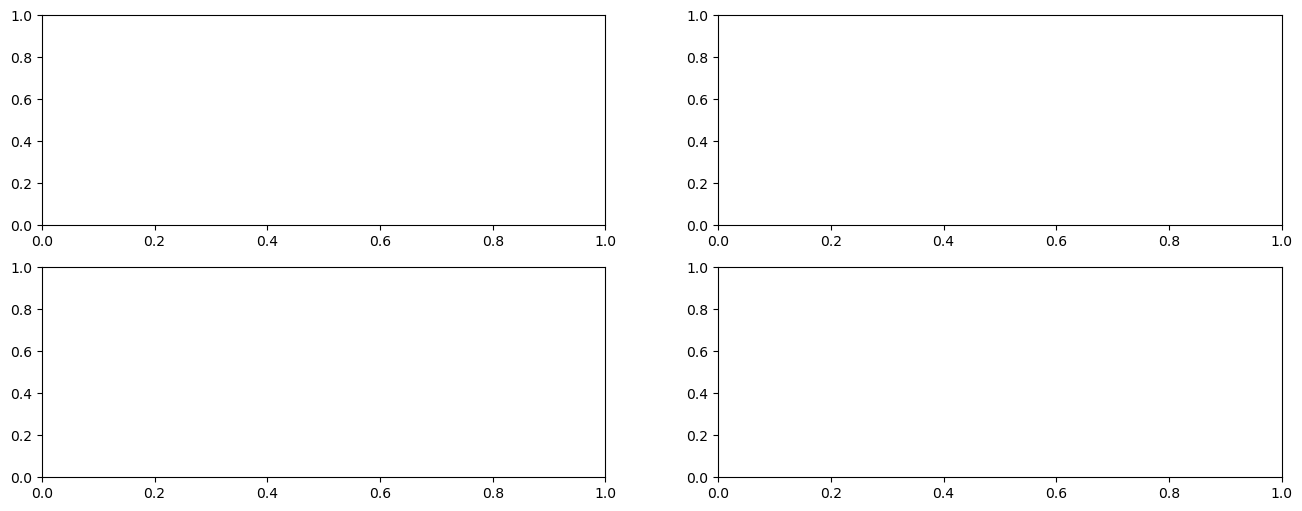

In [105]:

Stack_ensemble_Prediction( ABPO_STATION)  

In [53]:
def Accuracy_Model_Comparisoms():
    fig, axs = plt.subplots(2, 2,figsize=(12, 8))
    Models = ['Stacked_model','AR','MA','ARIMA','SARIMA']
    color = ['green','green','green','green','green']
    ABPO_accuracy_Score =[0.52019,7.2691,7.3845,1.8047,14.8654]
    
    ADIS_accuracy_Score = [0.2010,3.7129,3.6941,4.9239,6.5019]
    
    MAL2_accuracy_Score=[0.3709,5.0186,5.0273,5.0273,40.7269]
    
    NURK_accuracy_Score = [ 0.3151,7.6259,7.6757,3.8581,10.4412]
    
    axs[0, 0].bar(Models, ABPO_accuracy_Score,color = color)
    axs[0, 0].set_title('PREDICTION ACCURACY ASSESSMENT AT STATION ABPO',fontsize=10,fontweight='bold')
    axs[0,0].set_ylabel('RMSE Scores',fontsize=13,fontweight='bold')
    axs[0,0].set_xlabel('Models',fontsize=13,fontweight='bold')
    
    plt.setp(axs[0, 0].get_xticklabels(), rotation=45)
    
    axs[0, 1].bar(Models, ADIS_accuracy_Score,color = color)
    axs[0, 1].set_title('PREDICTION ACCURACY ASSESSMENT AT STATION ADIS',fontsize=10,fontweight='bold')
    plt.setp(axs[0, 1].get_xticklabels(), rotation=45)
    axs[0,1].set_ylabel('RMSE Scores',fontsize=13,fontweight='bold')
    axs[0,1].set_xlabel('Models',fontsize=13,fontweight='bold')
    
    
    axs[1, 0].bar(Models, MAL2_accuracy_Score,color = color)
    axs[1, 0].set_title('PREDICTION ACCURACY ASSESSMENT AT STATION MAL2',fontsize=10,fontweight='bold')
    axs[1,0].set_ylabel('RMSE Scores',fontsize=13,fontweight='bold')
    plt.setp(axs[1, 0].get_xticklabels(), rotation=45)
    axs[1,0].set_xlabel('Models',fontsize=13,fontweight='bold')
    
    axs[1, 1].bar(Models, NURK_accuracy_Score,color = color)
    axs[1, 1].set_title('PREDICTION ACCURACY ASSESSMENT AT STATION NURK',fontsize=10,fontweight='bold')
    axs[1,1].set_ylabel('RMSE Scores',fontsize=13,fontweight='bold')
    plt.setp(axs[1, 1].get_xticklabels(), rotation=45)
    axs[1,1].set_xlabel('Models',fontsize=13,fontweight='bold')
    
    for index,value in enumerate(ABPO_accuracy_Score):
        axs[0, 0].text(index, value-1.5, str(round(value,4)), ha='center', va='bottom',fontsize=12) if index == 4 else axs[0, 0].text(index, value-0.01, str(round(value,4)), ha='center', va='bottom',fontsize=12)
    for index,value in enumerate(ADIS_accuracy_Score):
        axs[0, 1].text(index, value-0.7, str(round(value,4)), ha='center', va='bottom',fontsize=12) if index==4 else axs[0, 1].text(index, value-0.006, str(round(value,4)), ha='center', va='bottom',fontsize=12)
    for index,value in enumerate(MAL2_accuracy_Score):
        axs[1, 0].text(index, value-4, str(round(value,4)), ha='center', va='bottom',fontsize=12) if index ==4 else axs[1, 0].text(index, value-0.007, str(round(value,4)), ha='center', va='bottom',fontsize=12)
    for index,value in enumerate(NURK_accuracy_Score):
        axs[1, 1].text(index, value-1, str(round(value,4)), ha='center', va='bottom' ,fontsize=12) if index == 4 else axs[1, 1].text(index, value-0.01, str(round(value,4)), ha='center', va='bottom' ,fontsize=12)

    fig.subplots_adjust(hspace=0.7)
    fig.suptitle('MODEL ACCURACY ASSESSMENT BASED ON ROOT MEAN SQUARE ERROR')
    
    

In [54]:
# Accuracy_Model_Comparisoms()

In [55]:
def Correlate_Time_Series_with_Stacked_Ensemble(Station_Name):
    station1_predicted_values = pd.Series(Stack_ensemble_Prediction(Station_Name))
    station2_predicted_values = Autoregressive_Forecasting(Station_Name,1)[3]
   
    plt.figure(figsize=(8, 2))
    plt.plot(station1_predicted_values,station2_predicted_values)
#     plt.plot(station2_predicted_values)
    plt.show()
    print(station1_predicted_values,station2_predicted_values)
   
    return station1_predicted_values.corr(station2_predicted_values)
    

In [56]:
# data = Read_GNSS_Data("IGS_ALL_DATA_DAILY_OSAH_imputed.csv")
# ABPO_STATION = Station_Extraction('ABPO',data)
# ADIS_STATION = Station_Extraction('ADIS',data)
# MAL2_STATION = Station_Extraction('MAL2',data)
# NURK_STATION = Station_Extraction('NURK',data)

In [57]:
# Correlate_Time_Series_with_Stacked_Ensemble(ADIS_STATION)

In [58]:
def Accuracy_Model_Comparisoms_AIC():
    fig, axs = plt.subplots(2, 2,figsize=(12, 8))
    Models = ['AR','MA','ARIMA','SARIMA']
    color = ['green','green','green','green']
    ABPO_accuracy_Score =[430.984,444.873,369.955,438.937]
    
    ADIS_accuracy_Score = [388.554,394.969,361.004,407.709]
    
    MAL2_accuracy_Score=[474.578,444.113,444.112,704.216]
    
    NURK_accuracy_Score = [ 449.662,456.241,419.956,459.130]
    
    axs[0, 0].bar(Models, ABPO_accuracy_Score,color = color)
    axs[0, 0].set_title('PREDICTION ACCURACY ASSESSMENT AT STATION ABPO',fontsize=10,fontweight='bold')
    axs[0,0].set_ylabel('AIC Scores',fontsize=13,fontweight='bold')
    axs[0,0].set_xlabel('Time Series Models',fontsize=13,fontweight='bold')
    
    
    plt.setp(axs[0, 0].get_xticklabels(), rotation=45)
    
    axs[0, 1].bar(Models, ADIS_accuracy_Score,color = color)
    axs[0, 1].set_title('PREDICTION ACCURACY ASSESSMENT AT STATION ADIS',fontsize=10,fontweight='bold')
    axs[0,1].set_ylabel('AIC Scores',fontsize=13,fontweight='bold')
    axs[0,1].set_xlabel('Time Series Models',fontsize=13,fontweight='bold')
    plt.setp(axs[0, 1].get_xticklabels(), rotation=45)
    
    axs[1, 0].bar(Models, MAL2_accuracy_Score,color = color)
    axs[1, 0].set_title('PREDICTION ACCURACY ASSESSMENT AT STATION MAL2',fontsize=10,fontweight='bold')
    axs[1,0].set_ylabel('AIC Scores',fontsize=13,fontweight='bold')
    axs[1,0].set_xlabel('Time Series Models',fontsize=13,fontweight='bold')
    plt.setp(axs[1, 0].get_xticklabels(), rotation=45)
    
    axs[1, 1].bar(Models, NURK_accuracy_Score,color = color)
    axs[1, 1].set_title('PREDICTION ACCURACY ASSESSMENT AT STATION NURK',fontsize=10,fontweight='bold')
    axs[1,1].set_ylabel('AIC Scores',fontsize=13,fontweight='bold')
    axs[1,1].set_xlabel('Time Series Models',fontsize=13,fontweight='bold')
    plt.setp(axs[1, 1].get_xticklabels(), rotation=45)
    
    
    for index,value in enumerate(ABPO_accuracy_Score):
        axs[0, 0].text(index, value-60, str(round(value,4)), ha='center', va='bottom',fontsize=12,color='w') 
    for index,value in enumerate(ADIS_accuracy_Score):
        axs[0, 1].text(index, value-60, str(round(value,4)), ha='center', va='bottom',fontsize=12,color='w') 
    for index,value in enumerate(MAL2_accuracy_Score):
        axs[1, 0].text(index, value-90, str(round(value,4)), ha='center', va='bottom',fontsize=12,color='w') 
    for index,value in enumerate(NURK_accuracy_Score):
        axs[1, 1].text(index, value-60, str(round(value,4)), ha='center', va='bottom' ,fontsize=12,color='w')

    fig.subplots_adjust(hspace=0.7)
    fig.suptitle('MODEL ACCURACY ASSESSMENT BASED ON  AKAIKE INFORMATION CRITERIA(AIC)')
    
    

In [59]:
# Accuracy_Model_Comparisoms_AIC()

# Replace GNSS with ERA_5

In [8]:
def Replace_GNSS_with_Era(Gnss_Data,Era_Data,Gnss_column_Name,Era5_Column_Name):
    combined_data = list(zip(Gnss_Data[Gnss_column_Name].iteritems(),Era_Data[Era5_Column_Name].iteritems()))
    for index, data1 in enumerate(combined_data):
        try:
            if combined_data[index][0][-1]== combined_data[index+1][0][-1]:
                gnss_value,gnss_value_list =list(data1), list(data1[0])
                gnss_value_list[-1]=gnss_value[-1][-1]
                gnss_value[0]=tuple(gnss_value_list)
                combined_data[index]= tuple(gnss_value)
                data_at_new_index=combined_data[index+1]
                gnss_value1,gnss_value_list1 =list(data_at_new_index), list(data_at_new_index[0])
                gnss_value_list1[-1]=gnss_value1[-1][-1]
                gnss_value1[0]=gnss_value_list1
                combined_data[index+1]=tuple(gnss_value1)
        except Exception as e:
            print(e,'this error is insignificant when its Index of range error')  
    Gnss_Data[Gnss_column_Name]=[new_gnss_data[0][-1] for new_gnss_data in combined_data]

In [35]:
# all_stations_pwv_2015 = data[data['YEAR'] == 2015]
# all_stations_pwv_2016 = data[data['YEAR'] == 2016]
# all_stations_pwv_2017 = data[data['YEAR'] == 2017]
# all_stations_pwv_2018 = data[data['YEAR'] == 2018]
# all_stations_pwv_2019 = data[data['YEAR'] == 2019]
# all_stations_pwv_2020 = data[data['YEAR'] == 2020]
# all_stations_pwv_2021 = data[data['YEAR'] == 2021]
# all_stations_pwv_2022 = data[data['YEAR'] == 2022]

TypeError: tuple indices must be integers or slices, not str

In [62]:
# all_stations_pwv_2015
# individual_year= data[data['YEAR'] == 2015]

In [26]:
# s=[{'b':5},{'b':5}]
# s

[{'b': 5}, {'b': 5}]

In [24]:

# selected_months = [1, 2, 3]
# all_stations_pwv_2015[all_stations_pwv_2015.index.month.isin(selected_months)]

,Unnamed: 0,STN,DOY,YEAR,MONTH,DAY,LAT,LON,h,ZTD_igs,p [hPa],ZHD,ZWD,Tm [K],Pi(factor),PWV_GTrop [K](mm)
date,,,,,,,,,,,,,,,,
2015-01-01,0,ABPO,1,2015,1,1,-19.018,47.229,1552.992,2.134266,843.637083,1.926467,0.207799,278.936250,0.001582,33.427499
2015-01-02,1,ABPO,2,2015,1,2,-19.018,47.229,1552.992,2.150071,843.319583,1.925742,0.224329,278.319167,0.001580,36.077243
2015-01-03,2,ABPO,3,2015,1,3,-19.018,47.229,1552.992,2.159808,842.504167,1.923880,0.235928,278.635417,0.001581,37.937256
2015-01-04,3,ABPO,4,2015,1,4,-19.018,47.229,1552.992,2.164476,841.370833,1.921292,0.243184,277.824167,0.001578,39.099472
2015-01-05,4,ABPO,5,2015,1,5,-19.018,47.229,1552.992,2.158428,841.223333,1.920955,0.237473,277.868333,0.001578,38.183576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-27,70213,ZAMB,86,2015,3,27,-15.426,28.311,1324.914,2.089733,868.690833,1.983029,0.106704,284.792083,0.001606,17.217396
2015-03-28,70214,ZAMB,87,2015,3,28,-15.426,28.311,1324.914,2.091549,868.112083,1.981708,0.109841,284.287083,0.001604,17.726118
2015-03-29,70215,ZAMB,88,2015,3,29,-15.426,28.311,1324.914,2.093677,868.330833,1.982207,0.111470,279.834583,0.001586,17.990098


In [42]:
# def year_extraction(data):
#     stations = []
#     for year in [2015,2016,2017,2018,2019,2020,2021,2022]:
#         individual_year= data[data['YEAR'] == year]
#         for item in ['ABPO','ADIS','BJCO','CGGN','CPVG','DAKR','DEAR','DJIG','HARB','HNUS','HRAO','MAL2','MBAR','MFKG','MOIU','NKLG','NURK','RABT','RBAY','RCMN','SBOK','SEY2','SEYG','SUTH','SUTM','TDOU','ULDI','VACS','WIND','YKRO','ZAMB']:
# #             stn = individual_year[individual_year['STN'] == item]
# #             Dec_Jan_Feb=stn[stn.index.month.isin([12, 1, 2])]['PWV_GTrop [K](mm)'].mean()
# #             Marc_April_May=stn[stn.index.month.isin([3, 4, 5])]['PWV_GTrop [K](mm)'].mean()
# #             June_July_August=stn[stn.index.month.isin([6, 7, 8])]['PWV_GTrop [K](mm)'].mean()
# #             Sep_Act_Nov=stn[stn.index.month.isin([9, 10,11])]['PWV_GTrop [K](mm)'].mean()
# #             stations.append((year,item,Dec_Jan_Feb,Marc_April_May,June_July_August,Sep_Act_Nov))
        
            
#             stations.append((year,item,stn['PWV_GTrop [K](mm)'].mean(),float(stn['LAT'].drop_duplicates()),float(stn['LON'].drop_duplicates())))
            
        
#     return stations
        

In [43]:
# extracted=year_extraction(data)

In [65]:
# year_2015=[]
# year_2016=[]
# year_2017=[]
# year_2018=[]
# year_2019=[]
# year_2020=[]
# year_2021=[]
# year_2022=[]
# # for data in year_extraction(data):
#     if 2015 == data[0] and:
#         year_2015.append(data)
#     if 2016 == data[0]:
#         year_2016.append(data)
#     if 2017 == data[0]:
#         year_2017.append(data)
#     if 2018 == data[0]:
#         year_2018.append(data)
#     if 2019 == data[0]:
#         year_2019.append(data)
#     if 2020 == data[0]:
#         year_2020.append(data)
#     if 2021 == data[0]:
#         year_2021.append(data)
#     if 2022 == data[0]:
#         year_2022.append(data)
        
    
    
    
    

In [66]:
# def write_to_excel(year_data):
#     year_column=[]
#     stn_column=[]
#     pwv_column=[]
#     Lat_column=[]
#     Lon_column=[]
#     for year,stn,pwv,Lat,Lon in year_data:

#         year_column.append(year)
#         stn_column.append(stn)
#         pwv_column.append(pwv)
#         Lat_column.append(Lat)
#         Lon_column.append(Lon)
#     return pd.DataFrame({'YEAR':year_column,'STN':stn_column,'PWV':pwv_column,'LAT':Lat_column,'LON':Lon_column})
        
        
        
        
        
        
        

In [67]:
# write_to_excel(year_2015).to_csv('Desktop/data_explore/2015_pwv.csv')
# write_to_excel(year_2016).to_csv('Desktop/data_explore/2016_pwv.csv')
# write_to_excel(year_2017).to_csv('Desktop/data_explore/2017_pwv.csv')
# write_to_excel(year_2018).to_csv('Desktop/data_explore/2018_pwv.csv')
# write_to_excel(year_2019).to_csv('Desktop/data_explore/2019_pwv.csv')
# write_to_excel(year_2020).to_csv('Desktop/data_explore/2020_pwv.csv')
# write_to_excel(year_2021).to_csv('Desktop/data_explore/2021_pwv.csv')
# write_to_excel(year_2022).to_csv('Desktop/data_explore/2022_pwv.csv')
# # write_to_excel(year_2015)

In [47]:
# abpo = []
# for data in extracted:
#     if 'ABPO'==data[1]:
#         abpo.append(data)
# #     if 2016 == data[0]:
# #         year_2016.append(data)
# #     if 2017 == data[0]:
# #         year_2017.append(data)
# #     if 2018 == data[0]:
# #         year_2018.append(data)
# #     if 2019 == data[0]:
# #         year_2019.append(data)
# #     if 2020 == data[0]:
# #         year_2020.append(data)
# #     if 2021 == data[0]:
# #         year_2021.append(data)
# #     if 2022 == data[0]:
# #         year_2022.append(data)
# abpo

[(2015,
  'ABPO',
  32.809366283333325,
  21.747104102891296,
  11.666067617336964,
  17.76898005206594),
 (2016,
  'ABPO',
  29.809280260439564,
  22.13593036263043,
  12.472638914510862,
  17.465310451714284),
 (2017,
  'ABPO',
  27.939482963888885,
  18.018092832347822,
  9.633301847184777,
  16.248650919670332),
 (2018,
  'ABPO',
  24.918292201555555,
  21.339417857608694,
  12.019082263456522,
  17.456159617527476),
 (2019,
  'ABPO',
  29.595808811999994,
  24.139225477391303,
  12.115125442119568,
  20.285823528439565),
 (2020,
  'ABPO',
  29.093974246483523,
  21.9635057486413,
  12.452560738249998,
  17.95524459593406),
 (2021,
  'ABPO',
  28.456372797111108,
  22.541975749978267,
  12.326722650695654,
  17.83565652424176),
 (2022,
  'ABPO',
  28.071720873888893,
  23.064684250086952,
  10.86775877,
  16.564708145285717)]

In [52]:
# Dec_Jan_Feb,Marc_April_May,June_July_August,Sep_Act_Nov,year=[],[],[],[],[]
# for item in abpo:
#     Dec_Jan_Feb.append(item[2])
#     Marc_April_May.append(item[3])
#     June_July_August.append(item[4])
#     Sep_Act_Nov.append(item[5])
#     year.append(item[0])
    
# d=pd.DataFrame({' Dec_Jan_Feb': Dec_Jan_Feb,'Marc_April_May':Marc_April_May,'June_July_August':June_July_August,'Sep_Act_Nov':Sep_Act_Nov,'year':year})
            
      
        
    
    
    

In [104]:
# names = []
# plotting= []

# for idx, row in d.iterrows():
#     to_tuple=tuple(row)
#     for i,cellvalue in enumerate(to_tuple):
#         if i!=4:
#             plotting.append(cellvalue)
            
#         if i ==0:
#             names.append(f'{int(to_tuple[-1])}-Dec_Jan_Feb')
#         elif i ==1:
#             names.append(f'{int(to_tuple[-1])}-Marc_April_May')
#         elif i ==2:
#             names.append(f'{int(to_tuple[-1])}-June_July_August')
#         elif i ==3:
#             names.append(f'{int(to_tuple[-1])}-Sep_Act_Nov')
        
            
            
        
        

# plotting

[32.809366283333325,
 21.747104102891296,
 11.666067617336964,
 17.76898005206594,
 29.809280260439564,
 22.13593036263043,
 12.472638914510862,
 17.465310451714284,
 27.939482963888885,
 18.018092832347822,
 9.633301847184777,
 16.248650919670332,
 24.918292201555555,
 21.339417857608694,
 12.019082263456522,
 17.456159617527476,
 29.595808811999994,
 24.139225477391303,
 12.115125442119568,
 20.285823528439565,
 29.093974246483523,
 21.9635057486413,
 12.452560738249998,
 17.95524459593406,
 28.456372797111108,
 22.541975749978267,
 12.326722650695654,
 17.83565652424176,
 28.071720873888893,
 23.064684250086952,
 10.86775877,
 16.564708145285717]

In [91]:
# names 

['2015.0-DJF',
 '2015.0-MAM',
 '2015.0-JJA',
 '2015.0-SON',
 '2016.0-DJF',
 '2016.0-MAM',
 '2016.0-JJA',
 '2016.0-SON',
 '2017.0-DJF',
 '2017.0-MAM',
 '2017.0-JJA',
 '2017.0-SON',
 '2018.0-DJF',
 '2018.0-MAM',
 '2018.0-JJA',
 '2018.0-SON',
 '2019.0-DJF',
 '2019.0-MAM',
 '2019.0-JJA',
 '2019.0-SON',
 '2020.0-DJF',
 '2020.0-MAM',
 '2020.0-JJA',
 '2020.0-SON',
 '2021.0-DJF',
 '2021.0-MAM',
 '2021.0-JJA',
 '2021.0-SON',
 '2022.0-DJF',
 '2022.0-MAM',
 '2022.0-JJA',
 '2022.0-SON']

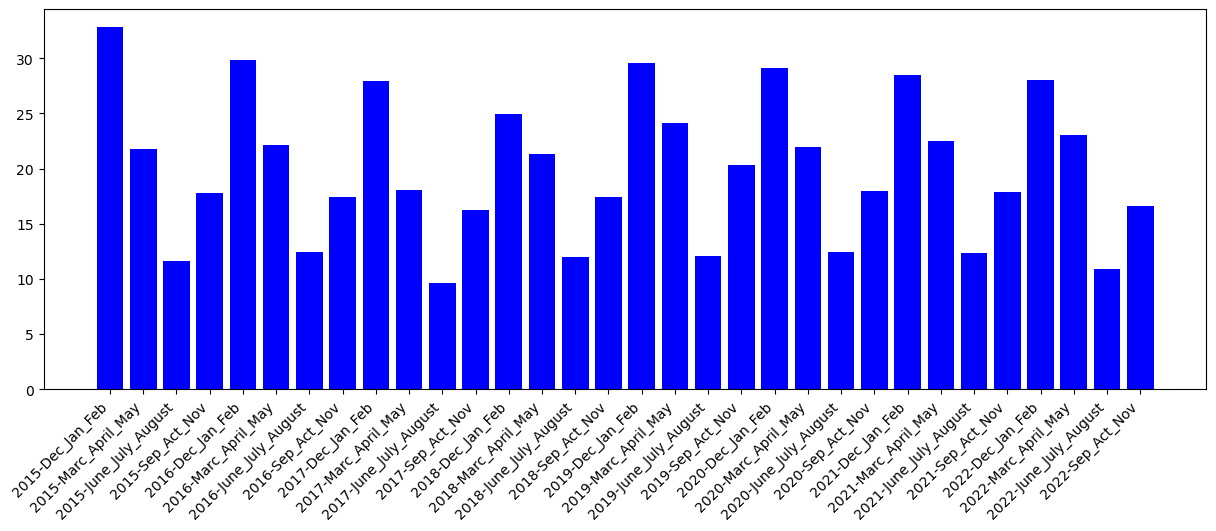

In [105]:
# plt.figure(figsize=(15, 10))
# plt.bar(names, plotting,color='b')
# plt.xticks(names,rotation=45,ha="right")
# plt.subplots_adjust(bottom=0.5)

In [36]:
df=three_month_extraction('ABPO',data)
for i in ['ADIS','BJCO','CGGN','CPVG','DAKR','DEAR','DJIG','HARB','HNUS','HRAO','MAL2','MBAR','MFKG','MOIU','NKLG','NURK','RABT','RBAY','RCMN','SBOK','SEY2','SEYG','SUTH','SUTM','TDOU','ULDI','VACS','WIND','YKRO','ZAMB']:
    df=df.append(three_month_extraction(i,data),ignore_index=True)





In [46]:
df.head(40)

,names,plotting
0,2015-Dec_Jan_Feb,33
1,2015-Marc_April_May,22
2,2015-June_July_August,12
3,2015-Sep_Oct_Nov,18
4,2016-Dec_Jan_Feb,30
5,2016-Marc_April_May,22
6,2016-June_July_August,12
7,2016-Sep_Oct_Nov,17
8,2017-Dec_Jan_Feb,28
9,2017-Marc_April_May,18


In [76]:
Dec_Jan_Feb_2015 = df[['names','plotting']][0::32]['plotting'].mean()
Marc_April_May_2015 = df[['names','plotting']][1::32]['plotting'].mean()
June_July_August_2015 = df[['names','plotting']][2::32]['plotting'].mean()
Sep_Oct_Nov_2015 = df[['names','plotting']][3::32]['plotting'].mean()

Dec_Jan_Feb_2016 = df[['names','plotting']][4::32]['plotting'].mean()
Marc_April_May_2016 = df[['names','plotting']][5::32]['plotting'].mean()
June_July_August_2016 = df[['names','plotting']][6::32]['plotting'].mean()
Sep_Oct_Nov_2016 = df[['names','plotting']][7::32]['plotting'].mean()

Dec_Jan_Feb_2017 = df[['names','plotting']][8::32]['plotting'].mean()
Marc_April_May_2017 = df[['names','plotting']][9::32]['plotting'].mean()
June_July_August_2017 = df[['names','plotting']][10::32]['plotting'].mean()
Sep_Oct_Nov_2017 = df[['names','plotting']][11::32]['plotting'].mean()

Dec_Jan_Feb_2018 = df[['names','plotting']][12::32]['plotting'].mean()
Marc_April_May_2018 = df[['names','plotting']][13::32]['plotting'].mean()
June_July_August_2018 = df[['names','plotting']][14::32]['plotting'].mean()
Sep_Oct_Nov_2018 = df[['names','plotting']][15::32]['plotting'].mean()

Dec_Jan_Feb_2019 = df[['names','plotting']][16::32]['plotting'].mean()
Marc_April_May_2019 = df[['names','plotting']][17::32]['plotting'].mean()
June_July_August_2019 = df[['names','plotting']][18::32]['plotting'].mean()
Sep_Oct_Nov_2019 = df[['names','plotting']][19::32]['plotting'].mean()

Dec_Jan_Feb_2020 = df[['names','plotting']][20::32]['plotting'].mean()
Marc_April_May_2020 = df[['names','plotting']][21::32]['plotting'].mean()
June_July_August_2020 = df[['names','plotting']][22::32]['plotting'].mean()
Sep_Oct_Nov_2020 = df[['names','plotting']][23::32]['plotting'].mean()

Dec_Jan_Feb_2021 = df[['names','plotting']][24::32]['plotting'].mean()
Marc_April_May_2021 = df[['names','plotting']][25::32]['plotting'].mean()
June_July_August_2021 = df[['names','plotting']][26::32]['plotting'].mean()
Sep_Oct_Nov_2021 = df[['names','plotting']][27::32]['plotting'].mean()

Dec_Jan_Feb_2022 = df[['names','plotting']][28::32]['plotting'].mean()
Marc_April_May_2022 = df[['names','plotting']][29::32]['plotting'].mean()
June_July_August_2022 = df[['names','plotting']][30::32]['plotting'].mean()
Sep_Oct_Nov_2022 = df[['names','plotting']][31::32]['plotting'].mean()


In [75]:
Dec_Jan_Feb_2022

,names,plotting
28,2022-Dec_Jan_Feb,28
60,2022-Dec_Jan_Feb,19
92,2022-Dec_Jan_Feb,52
124,2022-Dec_Jan_Feb,4
156,2022-Dec_Jan_Feb,19
188,2022-Dec_Jan_Feb,52
220,2022-Dec_Jan_Feb,29
252,2022-Dec_Jan_Feb,39
284,2022-Dec_Jan_Feb,26
316,2022-Dec_Jan_Feb,31


In [63]:
x_axis =['Dec_Jan_Feb_2015','Marc_April_May_2015','June_July_August_2015','Sep_Oct_Nov_2015','Dec_Jan_Feb_2016','Marc_April_May_2016','June_July_August_2016','Sep_Oct_Nov_2016','Dec_Jan_Feb_2017','Marc_April_May_2017','June_July_August_2017','Sep_Oct_Nov_2017','Dec_Jan_Feb_2018','Marc_April_May_2018','June_July_August_2018','Sep_Oct_Nov_2018','Dec_Jan_Feb_2019','Marc_April_May_2019','June_July_August_2019','Sep_Oct_Nov_2019','Dec_Jan_Feb_2020','Marc_April_May_2020','June_July_August_2020','Sep_Oct_Nov_2020','Dec_Jan_Feb_2021','Marc_April_May_2021','June_July_August_2021','Sep_Oct_Nov_2021','Dec_Jan_Feb_2022','Marc_April_May_2022','June_July_August_2022','Sep_Oct_Nov_2022']
y_axis =[globals()[variable_name] for variable_name in x_axis]

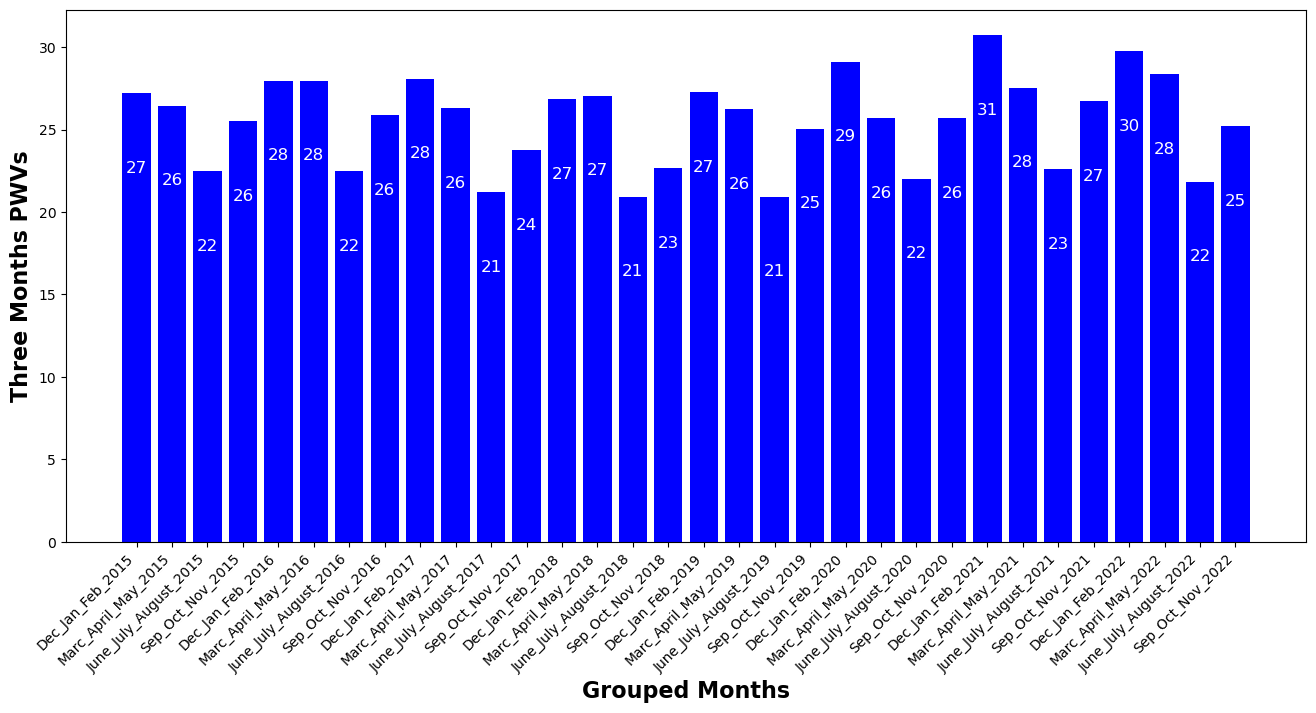

In [70]:
    plt.figure(figsize=(16, 14))
    plt.bar(x_axis, y_axis,color='b')
    plt.xlabel('Grouped Months',fontsize=16,fontweight='bold')
    plt.ylabel('Three Months PWVs',fontsize=16,fontweight='bold')
    plt.xticks(x_axis,rotation=45,ha="right")
    plt.subplots_adjust(bottom=0.5)
    for index,value in enumerate(y_axis):
        plt.text(index, value-5, str(round(value)), ha='center', va='bottom',fontsize=12,color='w') 

In [25]:
def three_month_extraction(station_name,data):
    stations = []
    for year in [2015,2016,2017,2018,2019,2020,2021,2022]:
        individual_year= data[data['YEAR'] == year]
        for item in ['ABPO','ADIS','BJCO','CGGN','CPVG','DAKR','DEAR','DJIG','HARB','HNUS','HRAO','MAL2','MBAR','MFKG','MOIU','NKLG','NURK','RABT','RBAY','RCMN','SBOK','SEY2','SEYG','SUTH','SUTM','TDOU','ULDI','VACS','WIND','YKRO','ZAMB']:
            stn = individual_year[individual_year['STN'] == item]
            Dec_Jan_Feb=stn[stn.index.month.isin([12, 1, 2])]['PWV_GTrop [K](mm)'].mean()
            Marc_April_May=stn[stn.index.month.isin([3, 4, 5])]['PWV_GTrop [K](mm)'].mean()
            June_July_August=stn[stn.index.month.isin([6, 7, 8])]['PWV_GTrop [K](mm)'].mean()
            Sep_Act_Nov=stn[stn.index.month.isin([9, 10,11])]['PWV_GTrop [K](mm)'].mean()
            stations.append((year,item,Dec_Jan_Feb,Marc_April_May,June_July_August,Sep_Act_Nov))
            
            
    statn = []
    for data in stations:
        if station_name==data[1]:
            statn.append(data)
            
    Dec_Jan_Feb,Marc_April_May,June_July_August,Sep_Act_Nov,year=[],[],[],[],[]
    for item1 in statn:
        Dec_Jan_Feb.append(item1[2])
        Marc_April_May.append(item1[3])
        June_July_August.append(item1[4])
        Sep_Act_Nov.append(item1[5])
        year.append(item1[0])

    d=pd.DataFrame({' Dec_Jan_Feb': Dec_Jan_Feb,'Marc_April_May':Marc_April_May,'June_July_August':June_July_August,'Sep_Act_Nov':Sep_Act_Nov,'year':year})
    names = []
    plotting= []

    for idx, row in d.iterrows():
        to_tuple=tuple(row)
        for i,cellvalue in enumerate(to_tuple):
            if i!=4:
                plotting.append(round(cellvalue))

            if i ==0:
                names.append(f'{int(to_tuple[-1])}-Dec_Jan_Feb')
            elif i ==1:
                names.append(f'{int(to_tuple[-1])}-Marc_April_May')
            elif i ==2:
                names.append(f'{int(to_tuple[-1])}-June_July_August')
            elif i ==3:
                names.append(f'{int(to_tuple[-1])}-Sep_Oct_Nov')
#     plt.figure(figsize=(16, 14))
#     plt.bar(names, plotting,color='b')
#     plt.xlabel('Grouped Months',fontsize=14,fontweight='bold')
#     plt.ylabel('Mean PWVs',fontsize=14,fontweight='bold')
#     plt.xticks(names,rotation=45,ha="right")
#     plt.subplots_adjust(bottom=0.5)
#     for index,value in enumerate(plotting):
#         plt.text(index, value-5, str(round(value,4)), ha='center', va='bottom',fontsize=12,color='w') 
    return pd.DataFrame({'names':names,'plotting':plotting})
#     return d
    

    
        
            
#             stations.append((year,item,stn['PWV_GTrop [K](mm)'].mean(),float(stn['LAT'].drop_duplicates()),float(stn['LON'].drop_duplicates())))
            

        

In [ ]:
# def extract_station(statn):
#     stn = []
#     for data in extracted:
#         if statn==data[1]:
#             abpo.append(data)
#     return stn

In [ ]:
# def return_dataframe():
#     Dec_Jan_Feb,Marc_April_May,June_July_August,Sep_Act_Nov,year=[],[],[],[],[]
#     for item in abpo:
#         Dec_Jan_Feb.append(item[2])
#         Marc_April_May.append(item[3])
#         June_July_August.append(item[4])
#         Sep_Act_Nov.append(item[5])
#         year.append(item[0])

#     d=pd.DataFrame({' Dec_Jan_Feb': Dec_Jan_Feb,'Marc_April_May':Marc_April_May,'June_July_August':June_July_August,'Sep_Act_Nov':Sep_Act_Nov,'year':year})

      